<a href="https://colab.research.google.com/github/demasion/DataPortfolio/blob/main/TTC_Subway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Raw Data Review and Cleaning

**Approach**:
1. Explore and clean raw data (i.e., missing values or duplicated values for attributes/columns that require unique entries).
2. Answer basic questions such as timeframe of the data, shape of the data that's being analyzed...etc.
3. EDA. Timeseries Analysis and bifurcation by year, and other trends, such as seasonality, impact of COVID19 Pandemic, delay assessment by frequency and duration

In [1]:
# import warnings
# import seaborn as sns
# import numpy as np
# from numpy import array
# import pandas as pd
# from pandas import concat
# import math
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.model_selection import ParameterGrid

# pd.plotting.register_matplotlib_converters()

# warnings.filterwarnings("ignore")

# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.CRITICAL)

# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# Data Source: https://www.kaggle.com/datasets/jsun13/toronto-subway-delay-data
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Importing data from G-Drive. We have two datasets, data, and delaycode
raw_data = pd.read_csv("/content/gdrive/My Drive/Data Science/Kaggle/ttcsubway/data.csv")
delaycode = pd.read_csv("/content/gdrive/My Drive/Data Science/Kaggle/ttcsubway/delay_code.csv")
weather = pd.read_csv("/content/gdrive/My Drive/Data Science/Kaggle/ttcsubway/weather.csv")
weather = weather[['date', 'avg_temperature']]

In [5]:
# Let's see how many attributes and rows we have
raw_data.shape

(143917, 10)

In [6]:
# Let's make the assumption that delays greater than or equal to 60s is considered as actual delay.
data_60 = raw_data['Min Delay'] >= 1
data_60.value_counts()

False    97467
True     46450
Name: Min Delay, dtype: int64

In [7]:
# Let's only look at the delays that are greater than or equal to 1 minute
raw_data = raw_data.loc[raw_data['Min Delay'] >=1]

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46450 entries, 0 to 143916
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       46450 non-null  object
 1   Time       46450 non-null  object
 2   Day        46450 non-null  object
 3   Station    46450 non-null  object
 4   Code       46450 non-null  object
 5   Min Delay  46450 non-null  int64 
 6   Min Gap    46450 non-null  int64 
 7   Bound      46000 non-null  object
 8   Line       46443 non-null  object
 9   Vehicle    46450 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.9+ MB


In [9]:
delaycode.head()

,Code #,RMENU CODE,Vehicle Type,CODE DESCRIPTION
0,1,EUAC,SUB,Air Conditioning
1,2,EUAL,SUB,Alternating Current
2,3,EUATC,SUB,ATC RC&S Equipment
3,4,EUBK,SUB,Brakes
4,5,EUBO,SUB,Body


In [10]:
# There are two Vehicle Types, Subway and SRT
delaycode['Vehicle Type'].value_counts()

SUB    129
SRT     71
Name: Vehicle Type, dtype: int64

In [11]:
# How many types of Code Descriptions Are There
delaycode['CODE DESCRIPTION'].unique().shape[0]

# Preparing the column header for RMENU Code so that we can perform the innerjoin later
delaycode.rename({"RMENU CODE":"Code"}, axis=1, inplace=True)
# Also renaming the date column from the weather dataframe for left join
weather.rename({"date":"Date", "avg_temperature":"avg_temp"}, axis=1, inplace=True)

In [12]:
# Converting date from Object to Date-Time
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])

In [13]:
# Perform the innerjoin and left join
data = pd.merge(raw_data, delaycode, on="Code", how="inner")
data = pd.merge(data, weather, on="Date", how="left")

#check joined dataframe
data.head(3)

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,CODE DESCRIPTION,avg_temp
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,52,SUB,Priority One - Train in Contact With Person,-12.65
1,2014-01-11,22:35,Saturday,BLOOR STATION,MUPR1,11,17,N,YU,5288,52,SUB,Priority One - Train in Contact With Person,4.20
2,2014-01-24,10:22,Friday,OSGOODE STATION,MUPR1,59,63,S,YU,5546,52,SUB,Priority One - Train in Contact With Person,-14.15


In [14]:
# Let's look at the data types before we move onto the analysis
data.info()

# Since Date is an object, for timeseries related analysis, let's convert that to a dateandtime type instead
data['Date'] = pd.to_datetime(data['Date'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46267 entries, 0 to 46266
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              46267 non-null  datetime64[ns]
 1   Time              46267 non-null  object        
 2   Day               46267 non-null  object        
 3   Station           46267 non-null  object        
 4   Code              46267 non-null  object        
 5   Min Delay         46267 non-null  int64         
 6   Min Gap           46267 non-null  int64         
 7   Bound             45821 non-null  object        
 8   Line              46260 non-null  object        
 9   Vehicle           46267 non-null  int64         
 10  Code #            46267 non-null  int64         
 11  Vehicle Type      46267 non-null  object        
 12  CODE DESCRIPTION  46267 non-null  object        
 13  avg_temp          46267 non-null  float64       
dtypes: datetime64[ns](1), 

In [15]:
# Based on the initial non-null counts, "Bound" and "Line" appear to be missing some values compared to the ohter attributes/features. Let's investigate.
num_unique_lines = len(data["Line"].unique())
num_unique_bounds = len(data["Bound"].unique())

print(f"Number of unique lines is: {num_unique_lines}\nNumber of unique bounds is :{num_unique_bounds}")

Number of unique lines is: 9
Number of unique bounds is :9


Observations:
1. There should only be 3 unique lines. Yonge-University, Bloor-Danforth, Sheppard.
2. There should only be 4 unique bounds, which are: EB, WB, NB, SB.

In [16]:
# Let's first look at bound data
data['Bound'].value_counts()

# The above query returned W, N, S, and E as bound directions. We can get rid of the other misc entries since they don't represent a large portion of the data
irr_bounds = list(data['Bound'].value_counts()[4:].index)
irr_bounds

['B', '5', '0', 'R']

In [17]:
# Replacing the non-relevant bound data with nan instead
for i in irr_bounds:
  data.loc[data["Bound"] == i, "Bound"] = np.nan

In [18]:
# Let's look at lines data now... other than the major subway lines: YU, BD, SRT, SHP, we see a combination/concat of multiple lines. For example, YU/BD.
# However, since the percentage is small, at 1.39%, these entries can become obsolete, and gets converted into NaN
non_mline_per = sum(data["Line"].value_counts()[4:]) / sum(data["Line"].value_counts().values)
print(f"Percentage of Non-Major Subway Lines is: {non_mline_per:.2%}")

Percentage of Non-Major Subway Lines is: 0.02%


In [19]:
# Let's identify and replace the non-major subway lines
non_mline = list(data['Line'].value_counts().index[4:])

# Iterating through the list and replace with nan if there's a match
for i in non_mline:
  data.loc[data["Line"] == i, "Line"] = np.nan

#2 - EDA

A few of the major questions that I would like to understand as part of the EDA exercise:

1. What is the timeframe of the dataset?
2. Annual trend of delays yoy
3. Monthly trend of delays
4. Top 5 stations by # of delays?
5. What are the top 5 errors and their relative %? and avg mins delay?
6. Is there weekday trends for delay (i.e., more delay on specific days of the week?)
7. What about time? Any associations?

Prediction Model
Can we predict the delay time based on the other given attributes?

In [20]:
# Since we were able to replace the unwanted entries for Bound and Line with nan, let's go ahead and remove those from the dataset.
data = data.dropna()

##2.1 - Dataset Timeframe

In [21]:
# to find the timeframe, let's take a look at the Date attribute

# defining a function to display only YYYY-M-DD
def rem_time(d):
    s = ''
    s = str(d.year) + '-' + str(d.month) + '-' + str(d.day)
    return s

min_date = data['Date'].min()
max_date = data['Date'].max()
print(f"The TTC delay data collected is between {rem_time(min_date)} and {rem_time(max_date)}")

The TTC delay data collected is between 2014-1-1 and 2021-6-30


As per the timeframe data above, we are working with approximately 7.5 years of subway delay data.

##2.2 - Annual, Monthly, and Weekday Delay Trends

**Annual Trends**

In [22]:
data.head(5)

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,CODE DESCRIPTION,avg_temp
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,52,SUB,Priority One - Train in Contact With Person,-12.65
1,2014-01-11,22:35,Saturday,BLOOR STATION,MUPR1,11,17,N,YU,5288,52,SUB,Priority One - Train in Contact With Person,4.20
2,2014-01-24,10:22,Friday,OSGOODE STATION,MUPR1,59,63,S,YU,5546,52,SUB,Priority One - Train in Contact With Person,-14.15
3,2014-01-26,16:55,Sunday,DUFFERIN STATION,MUPR1,112,117,E,BD,5131,52,SUB,Priority One - Train in Contact With Person,-11.50
4,2014-01-28,12:18,Tuesday,CHRISTIE STATION,MUPR1,54,57,E,BD,5850,52,SUB,Priority One - Train in Contact With Person,-16.39


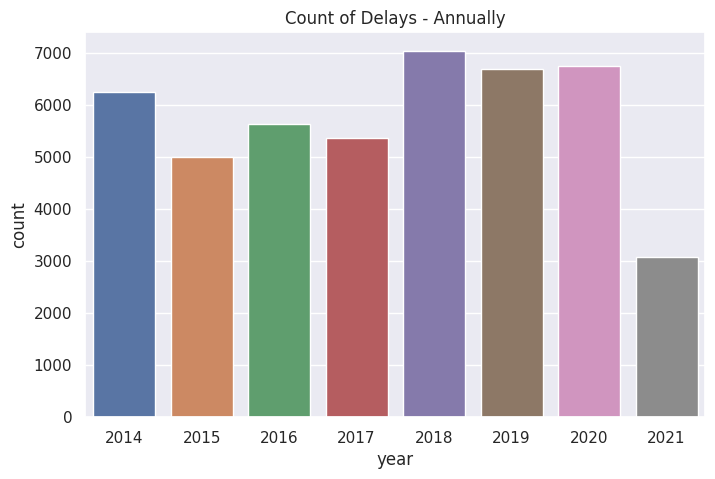

In [23]:
sns.set(rc={'figure.figsize':(8,5)})

 # adding year and month to the dataset
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month

# since each row is a delay by itself, we can do a count plot on the year
sns.countplot(x=data['year']).set(title="Count of Delays - Annually")
plt.show()

**Trends observed from the annual trend plot:**
1. There is a significant increase in # of delays since 2017. Roughly 1.8k increase from 2017 to 2018. Further research has indicated that Line 1 (Yonge and University) Subway extension to Vaughan Metropolitan Centre opened on December 17, 2017, which included 5 stations in between the existing Sheppard West (used to be called Downsview) and Vaughan Metropolitan Centre. The addition of 6 new subway stations will definitely influence the route duration, # of passengers, and # of delays for the subway. Thus, given the evolution of the Subway line, it is expected to see # of delays increase in 2018.
2. 2021 data only goes up to June 30 2021. It is reasonable that the # of delays is significantly lower than the previous years.

**Monthly Trends**

Since year 2020 and 2021 are likely to be influenced by external factors (COVID19 and limited data), let's only look at the data from 2014 to 2019 for now.

In [24]:
# Defining an average function that can be used to calculate avg values from a list
def Average(lst):
  return sum(lst) / len(lst)

avg_year_list = [2014, 2015, 2016, 2017, 2018, 2019]
# Returns T/F, where position 0 is True, and 1 is False
avg_annual = data['year'].isin(avg_year_list).value_counts().to_list()
avg_monthly = avg_annual[0]/len(avg_year_list)/12

print(f"The average number of delays per month from 2014 to 2019 is: {round(avg_monthly, 2)}")

The average number of delays per month from 2014 to 2019 is: 499.53


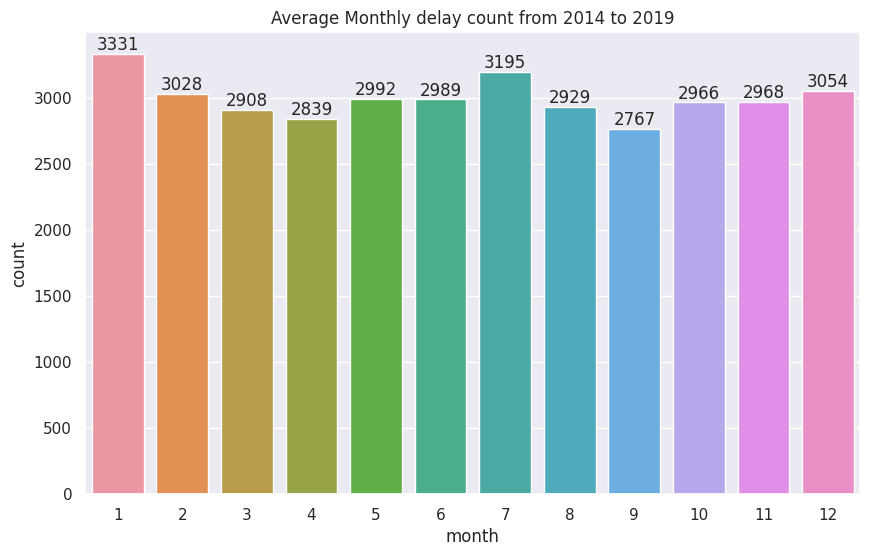

In [25]:
# Plotting out the the monthly # of delays from 2014 to 2019
sns.set(rc={'figure.figsize':(10,6)})

data_fullyear = data.loc[data['year'].isin(avg_year_list)]
ax = sns.countplot(x=data_fullyear['month'])
ax.bar_label(ax.containers[0])
ax.set_title('Average Monthly delay count from 2014 to 2019')
plt.show()

Majority of the months are between 2,800 and 3,000 count of delays each month during the period of 2014 to 2019. It is interesting to note that for August, count of delays is visibily higher than the other months. This makes sense as August is the travel month, where students are on summer break, resulting in higher traffic, and potentially more delays / distruptions.

Higher delay counts in December, January, and February also makes sense as Winter season tend to have higher risk of personnel slipping, track blockage.

**Weekly Trends**

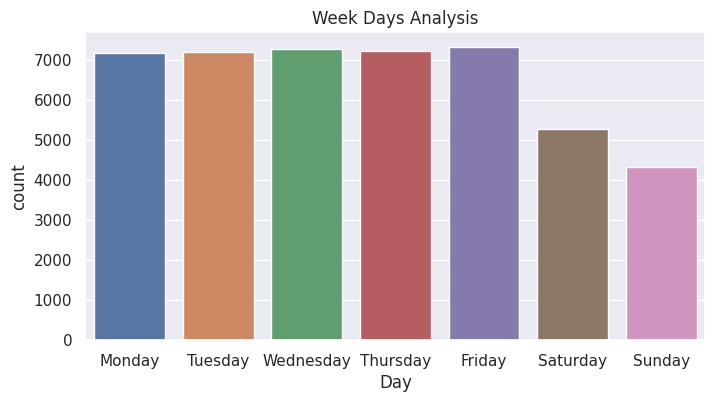

In [26]:
# The Day column represents day of the week, of the delay. Let's do a countplot of the weekdays, from 2014 to 2019
# Day order list created to order the days in the desired Monday-Sunday order
sns.set(rc={'figure.figsize':(8,4)})

day_order = ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = sns.countplot(x=data['Day'], order=day_order)
ax.set_title('Week Days Analysis')
plt.show()

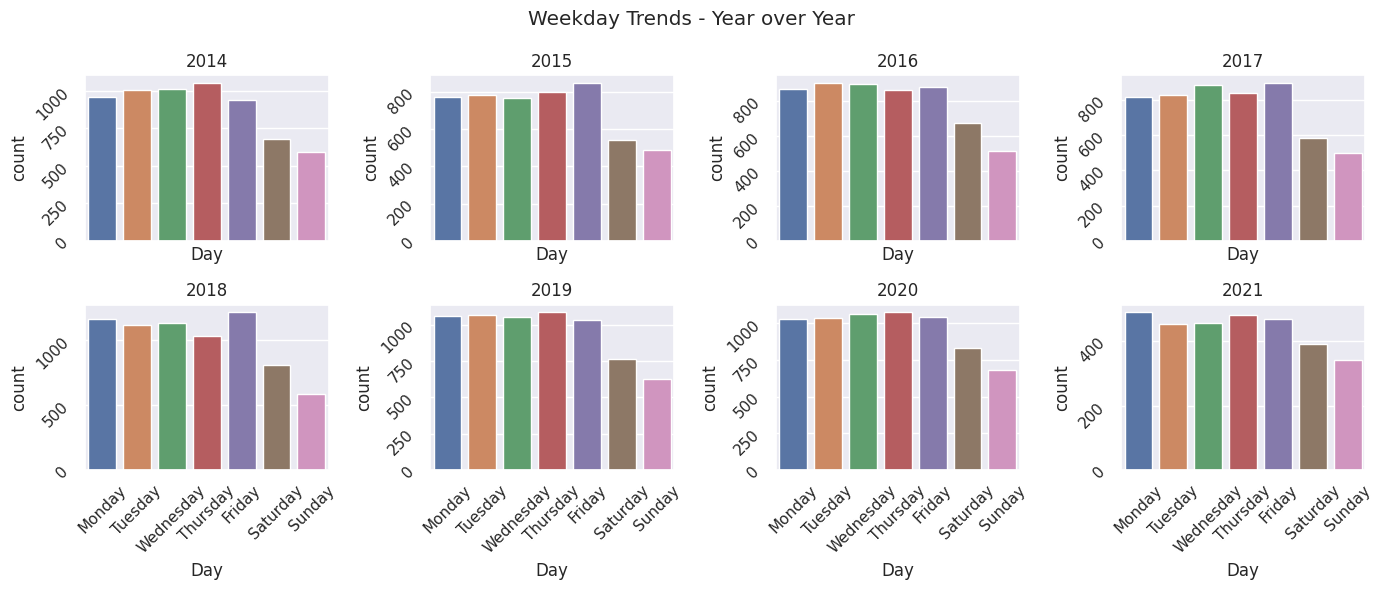

In [27]:
# Subplot to plot out each delay and their weekday trend YoY
fig, axes =plt.subplots(2,4, figsize=(14,6), sharex=True)

year_list = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

axes = axes.flatten()
for ax, i in zip(axes, year_list):
  sns.countplot(x=data.loc[data['year']== i]['Day'], ax=ax, order=day_order).set(title=i)
  ax.tick_params(labelrotation=45)

fig.suptitle('Weekday Trends - Year over Year')
plt.tight_layout()
plt.show()

**Key Takeaway**
1. No unique weekday trends were observed from the dataset. Saturday and Sunday have lower count of delays compared to Monday to Friday, which is expected since there's lower traffic on the weeekends (assuming that majority of the Subway riders during the weekday are commuting to work)
2. Similar trends observed for year 2020, where there's a decrease in the count of delays reported due to the lower traffic as a result of the COVID19 pandemic (presumably that the city was under lock-down for majority of the year)
3. Lower count of delays for 2021 is caused by both the COVID19 pandemic, lockdown, Work From Home / hybrid workforce, coupled with limited data (6 months) reported for the year

##2.3 - Seasonality Trends

In [28]:
# It would be interesting to see if the top 5 # of delays has been the same or different month over month. It might give us some insights to the spikes in July and August.

# Initializing empty dictionary for monthly top 10 and empty list for months (for iteration purposes)
monthly_top10 = {}
months = list(range(1,13))

# Iterating through each month and identify the top 10 errors for each month, and append to the monthly_top10 dictionary
for i in months:
  top_error = list(data.loc[data['month']==i]['CODE DESCRIPTION'].value_counts()[:10].index)
  top_error_count = list(data.loc[data['month']==i]['CODE DESCRIPTION'].value_counts()[:10].values)

  j=0
  for error in top_error:
    if error in monthly_top10.keys():
      monthly_top10[error] += top_error_count[j]
    else:
      monthly_top10[error] = top_error_count[j]
  j+=1

# Note that the resulted dictionary will likely have more than 10 error codes as top 10 may vary from month to month
# Sorting the dictionary from high to low based on count of delays
dict(sorted(monthly_top10.items(), key=lambda item: item[1], reverse=True))

{'Disorderly Patron': 4477,
 'Door Problems - Faulty Equipment': 4477,
 'Injured or ill Customer (On Train) - Medical Aid Refused': 4477,
 'Injured or ill Customer (On Train) - Transported': 4477,
 'Passenger Assistance Alarm Activated - No Trouble Found': 4477,
 'Misc. Transportation Other - Employee Non-Chargeable': 4477,
 'Passenger Other': 3810,
 'Miscellaneous Other': 3573,
 'No Operator Immediately Available - Not E.S.A. Related ': 2277,
 'ATC Project': 1937,
 'Door Problems - Debris Related': 1637,
 'Transportation Department - Other': 1364,
 'Miscellaneous Speed Control': 1324,
 'No Operator Immediately Available ': 790,
 'Operator Not In Position': 529,
 'Unauthorized at Track Level': 404,
 'Operator Violated Signal': 263}

**Key takeaways:**
1. Top 8 monthly delays are consistant from 2014 to 2021
2. Injured or ill Customer has the highest count of delays, bifurcated to 3 categories (Medical Aid Refused, Transported On Train, and Transported In Station)
3. Speed Control and Operator Overspeeding are also significantly high
4. Another key delay is caused by Passenger Assistance Alarm Activated - No Trouble Found (does this indicate false alarms? or accidental activation of the alarm?)

The delay codes below are likely impacted by higher traffic. The hypothesis here is that, higher the traffic, higher the flow of people, higher the potential for alarms and injuries.

1. Passenger Assistance Alarm Activated - No Trouble Found
2. Injured or ill Customer (In Station) - Transported

Both of these delay codes can be influenced by higher traffic. Let's check if the July and August #s have any significant increase on these delay codes.

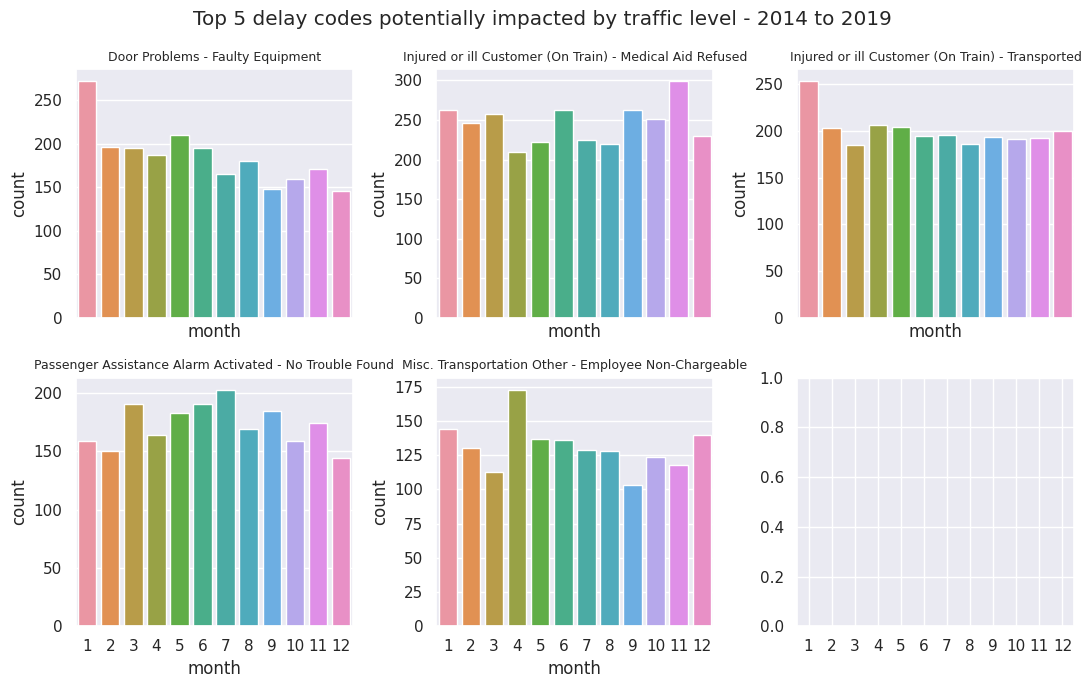

In [29]:
  # Storing the delay codes in a list. These are the delay codes that we've deem to be "potentially" impacted by the traffic level (higher the traffic, higher the delay)
top5_delay = ['Door Problems - Faulty Equipment',
              'Injured or ill Customer (On Train) - Medical Aid Refused',
              'Injured or ill Customer (On Train) - Transported',
              'Passenger Assistance Alarm Activated - No Trouble Found',
              'Misc. Transportation Other - Employee Non-Chargeable']

# Subplot to plot out each delay and their monthly trends
fig, axes =plt.subplots(2,3, figsize=(11,7), sharex=True)
axes = axes.flatten()
for ax, i in zip(axes, top5_delay):
    sns.countplot(x=data.loc[data['CODE DESCRIPTION']== i]['month'], ax=ax).axes.set_title(i, fontsize=9)

fig.suptitle('Top 5 delay codes potentially impacted by traffic level - 2014 to 2019')
plt.tight_layout()
plt.show()

# Alternative plotting method
# for i in top5_delay:
#   fig, ax = plt.subplots(1,1, figsize=(10, 6))
#   sns.countplot(x=data.loc[data['CODE DESCRIPTION']== i]['month']).set(title=i)

**Key Takeaway:**

The plots above display the top 5 delay codes that could potentially be affected by traffic fluctuations, as the cumulative count between 2014 and 2020.
1. Correlation between traffic and [injured or ill customer (on train) - medical aid refused and Transportation Other - Employee Non-Chargeable] cannot be established. No monthly trends were observed.
2. There appears to be a direct relationship between traffic (# of passengers) and the # of delays for Passenger Assistance Alarm Activated No Trouble Found
  - The assumption here could be that as more children and foreign travellers take the subway in the Summer, there is a higher likelyhood of children accidently pressing on the alarm button, or foreigners activiating the alarm due to language barriers (i.e., treating it as a method of asking for directions? or general help?). Will need further classification on who reported these error codes to confirm and draw further analysis.
3. Injured or ill Customer (On Train) - Transported is significantly higher for the month of January.
  - The hypothesis here is that as the weather gets colder in Toronto, homeless people looking for shelter often resort to subway corridors / pathways, and probably on the subway (speaking from personal experience commuting in Winter vs.other Seasons). As a result, there could be higher likelihood of disturbances and potentially injury. Since this delay code does not distinguish injury and illness, further bifurcation of the category is required for further analysis.
4. Door Problems - Faulty Equipment has a significantly higher # of delays in January. As January is usually the coldest month in Toronto (Probably Canada aswell), it is likely that the door related problems are caused by extreme cold weather / climate. For example, door jamming due to frost build-up, or mechanical failures due to extreme cold temperature. Further bifurcation of this delay code would assist in further identification the reasons.


##2.4 - Year 2020 EDA (COVID Trends)

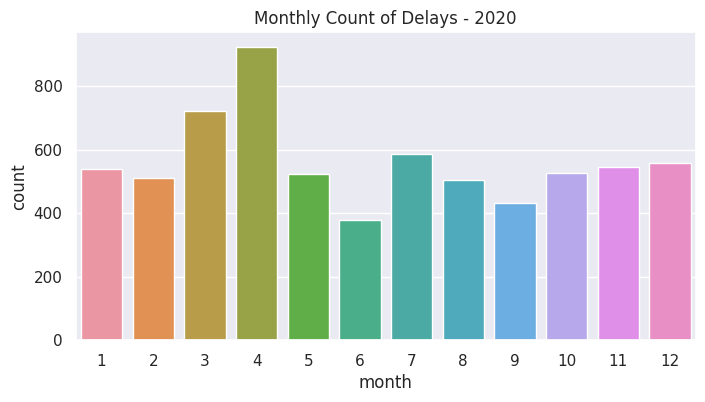

In [30]:
# Let's take a look at the monthly numbers in 2020
data_2020 = data.loc[data['year']==2020]
avg_2020 = data_2020['month'].value_counts().tolist()

sns.countplot(x=data_2020['month']).set(title="Monthly Count of Delays - 2020")
plt.show()

In [31]:
 # Let's compare the avg. #s from 2020 against the previous years avg again
# Note that avg_annual[0] is the total count of delays over 6 years, from 2014 to 2019. So to arrive at the monthly avg, we divide this number by 6 and 12
m_avg_2020 = round(sum(avg_2020)/len(avg_2020), 2)
print(f"2020's average # of delays is {m_avg_2020}, while the average annual # of delays from the previous years is {round(avg_monthly, 2)}")

2020's average # of delays is 562.17, while the average annual # of delays from the previous years is 499.53


**Key Takeaway:**

1. 2020's monthly average # of delays is higher than the previous years. This is likely caused by the lower # of delays (fewer stations extending to Vaughan MC) prior to 2017. When looking at the cumulative annual # of delays, year 2020 did not drop significantly compared to 2018 and 2019, despite going through COVID19 pandemic.
2. COVID19 Timeline: March 17, 2020 - Ontario announced lock-down (closure of facilities). April 2, 2020 - Social distancing by law implementation. April 23, 2020 - TTC lays off 1200 employees. This timeline supports the trends observed in the monthly delay count plot, where May had a drastic decrease in # of delays and sustained until the end of the year (likely caused by lower traffic, lower frequency of subways). This is also supported by that non-essential workers have shifted from On-site to Remote work approach, leading to decrease in commuters.

##2.5 - Seasonality Analysis

In [32]:
# For the sake of this exercise, since the data for 2021 is incomplete, it is best to disgard them
# from the overall analysis
data.drop(data[data['year']==2021].index, inplace=True)

In [33]:
# Other than the apparent decline in # of delays in 2020 and incomplete data in 2021, no other trends were observed
# Let's look at seasonality - unique mapping since the seasons in Canada are different.. longer winter and spring, shorter summer and fall

# Defining the mapping in a dictionary
s_map = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'
    }

# Mapping the map dict against the month (make copy and map)
data['season'] = data['month']
data['season'] = data['season'].map(s_map)

In [34]:
data.head(5)

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,CODE DESCRIPTION,avg_temp,year,month,season
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,52,SUB,Priority One - Train in Contact With Person,-12.65,2014,1,Winter
1,2014-01-11,22:35,Saturday,BLOOR STATION,MUPR1,11,17,N,YU,5288,52,SUB,Priority One - Train in Contact With Person,4.20,2014,1,Winter
2,2014-01-24,10:22,Friday,OSGOODE STATION,MUPR1,59,63,S,YU,5546,52,SUB,Priority One - Train in Contact With Person,-14.15,2014,1,Winter
3,2014-01-26,16:55,Sunday,DUFFERIN STATION,MUPR1,112,117,E,BD,5131,52,SUB,Priority One - Train in Contact With Person,-11.50,2014,1,Winter
4,2014-01-28,12:18,Tuesday,CHRISTIE STATION,MUPR1,54,57,E,BD,5850,52,SUB,Priority One - Train in Contact With Person,-16.39,2014,1,Winter


<Axes: xlabel='season', ylabel='count'>

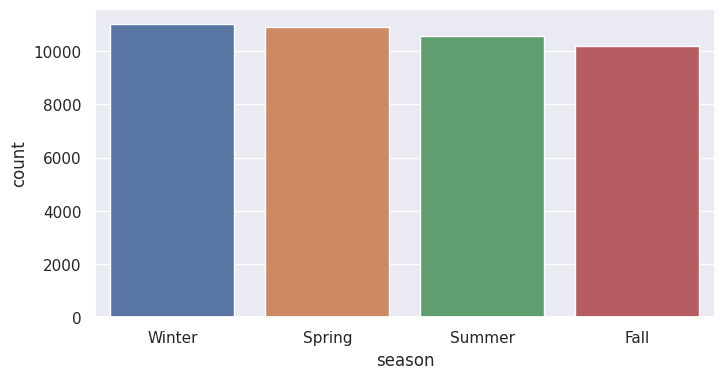

In [35]:
sns.countplot(x=data['season'])

Similar count of delays by season. No significant trends observed. Slightly higher count of delays observed in Winter and Spring. Note that the seasons are evenly distributed in terms of # of months, which is 3.

In [36]:
# Since daily counts aren't giving us the trends we needed, let's look at the monthly trends

data_monthly = data.groupby([data['year'],
                   data['month']])['Code #'].count().reset_index(name="delay_count")

data_monthly['date'] = pd.to_datetime(data_monthly[['year', 'month']].assign(DAY=1))

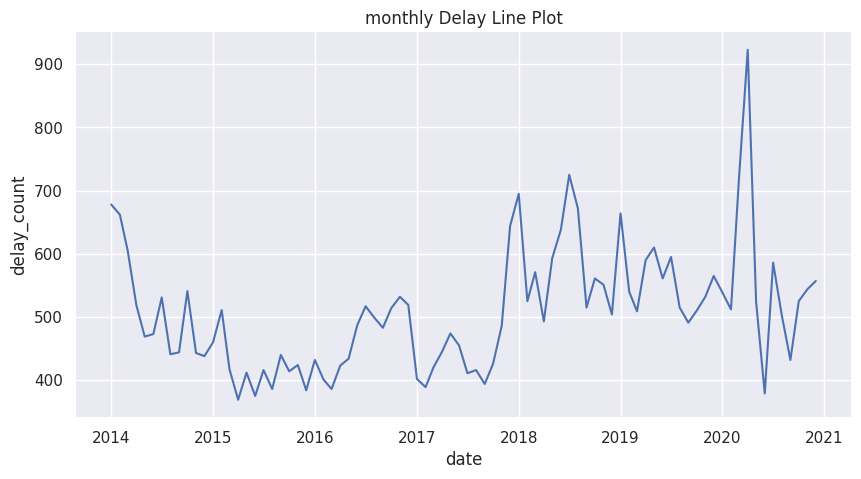

In [37]:
# Let's use the scatterplot to see monthly delays
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.lineplot(x="date", y="delay_count",
                data=data_monthly, ax=ax)
plt.title("monthly Delay Line Plot")
plt.show()

Again, the same trends from the monthly bar charts is observed here for the line plot, where an increase in count of delays is observed in 2018, along with some seasonality trends (higher delay in the Winter seasons), as well as the significant drop in # of delays around May 2020.

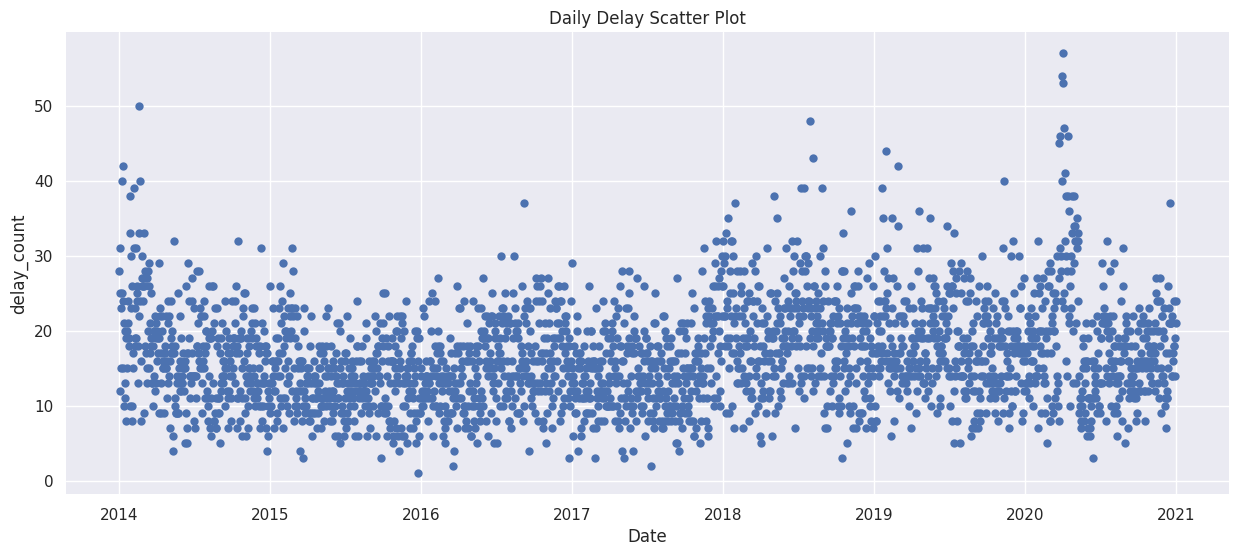

In [38]:
# Let's visualize the daily delay counts through a scatter plot. This will allow us see how daily delay counts are distributed.

data_daily = data.groupby(['Date'])['Code #'].count().reset_index(name='delay_count')
data_daily.head(5)

f, ax = plt.subplots(figsize=(15, 6))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Date", y="delay_count",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=data_daily, ax=ax)
plt.title("Daily Delay Scatter Plot")
plt.show()

Majority if the daily delay counts are roughly 10-20. Comparing 2015-2017 against 2018-2020, we can see that the latter has a slightly higher cluster at arond 13-22 range vs. the 10-20 range between 2015 and 2017. This again is aligned with annual trends that we've identified previously.

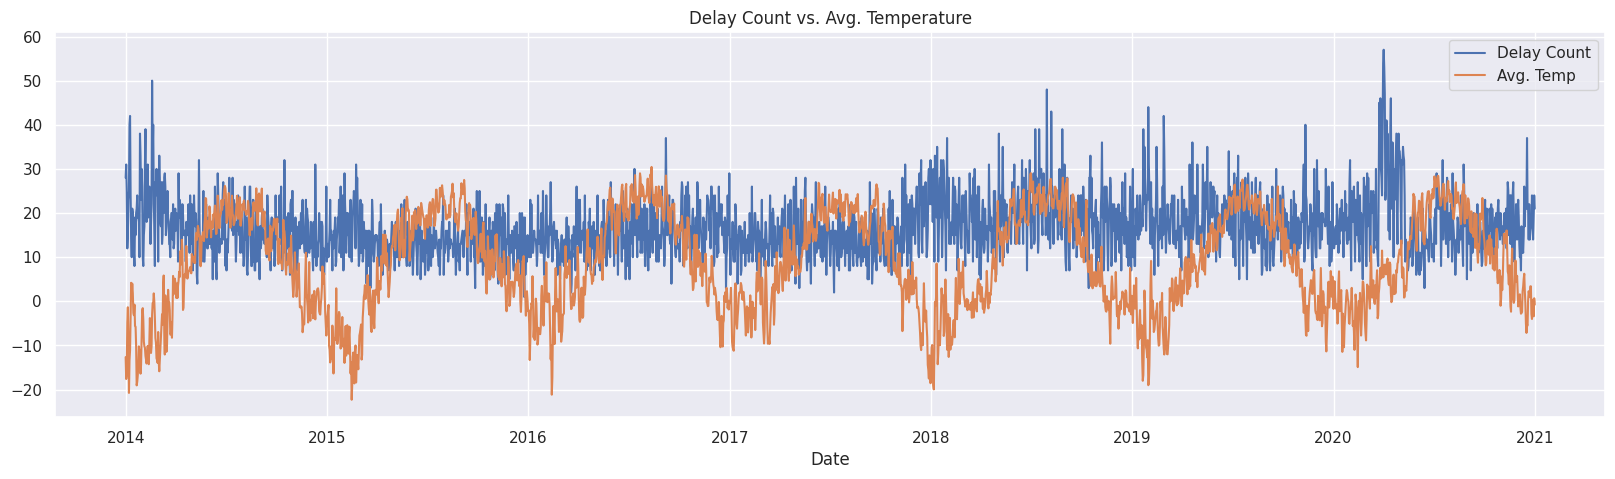

In [39]:
# Daily count of delays vs. daily avg delay duration vs. avg temperature
plt.figure(figsize=(20,5))

data.groupby(data['Date'].dt.date)["Code #"].count().plot(kind="line", label="Delay Count")
data.groupby(data['Date'].dt.date)["avg_temp"].mean().plot(kind="line", label="Avg. Temp")
plt.title("Delay Count vs. Avg. Temperature")
plt.legend()
plt.show()

**key Takeaway:**
No direct trends were observed by plotting the daily delay count and daily average temperature. Let's plot the daily temperature (x-axis) against the daily # of delays (y-axis) to see if trends can be observed.

In [40]:
# Extracting the daily # of delays and join the weather data to arrive at a dataframe with date, delay count, and avg. temp
daily_count = pd.DataFrame(data['Date'].value_counts().reset_index())
daily_count.rename(columns={"Date":"delay_count", "index":"Date"}, inplace=True)
daily_count['Date'] = pd.to_datetime(daily_count['Date'])
delay_temp = pd.merge(daily_count, weather, on="Date", how="left")
delay_temp.head(5)

,Date,delay_count,avg_temp
0,2020-04-01,57,5.60
1,2020-03-31,54,5.44
2,2020-04-02,53,8.30
3,2014-02-18,50,-2.95
4,2018-07-30,48,21.95


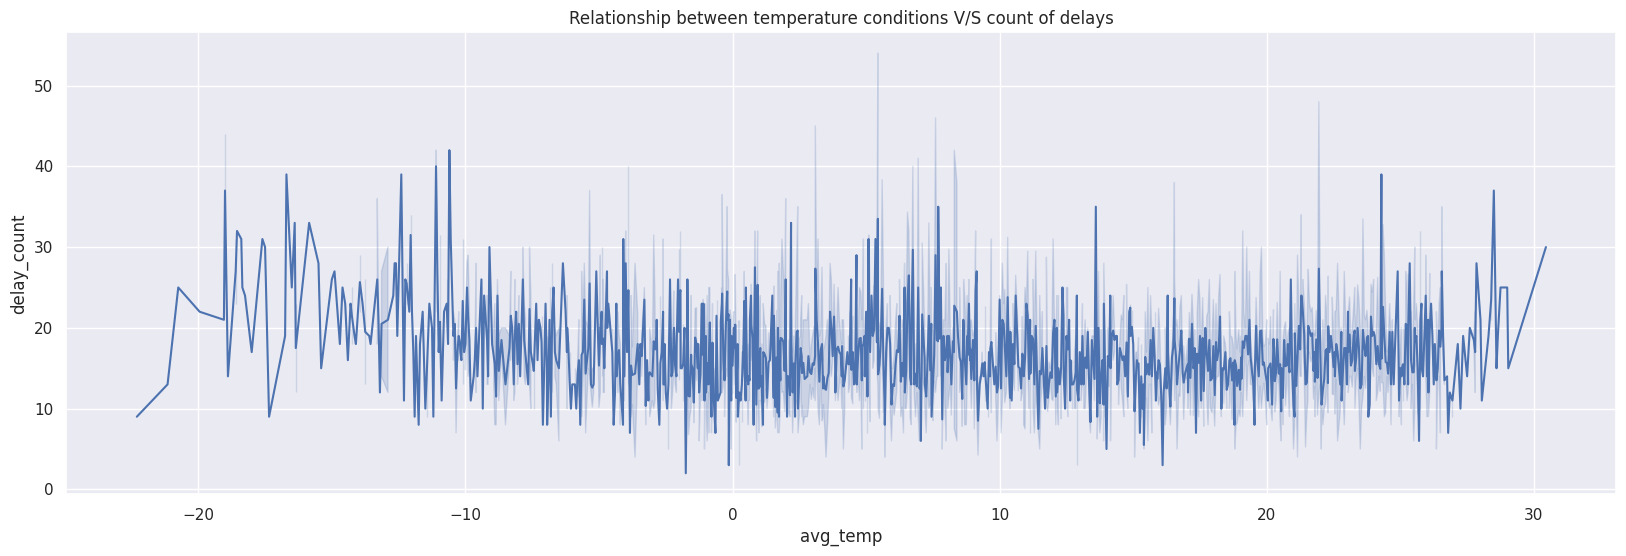

In [41]:
# Plotting out weather vs. count
plt.figure(figsize=(20,6))
sns.lineplot(x='avg_temp', y='delay_count', data=delay_temp)
plt.title('Relationship between temperature conditions V/S count of delays')
plt.show()

In [42]:
# Extracting the daily # of delays and join the weather data to arrive at a dataframe with date, avg. delay and avg. temp
daily_avg = data.resample('D', on='Date')['Min Delay'].mean().reset_index()
daily_avg['Date'] = pd.to_datetime(daily_avg['Date'])
delay_avg = pd.merge(daily_avg, weather, on="Date", how="left")
delay_avg.head(5)

,Date,Min Delay,avg_temp
0,2014-01-01,7.250000,-12.65
1,2014-01-02,5.129032,-17.60
2,2014-01-03,6.280000,-16.50
3,2014-01-04,5.250000,-4.80
4,2014-01-05,5.800000,-1.35


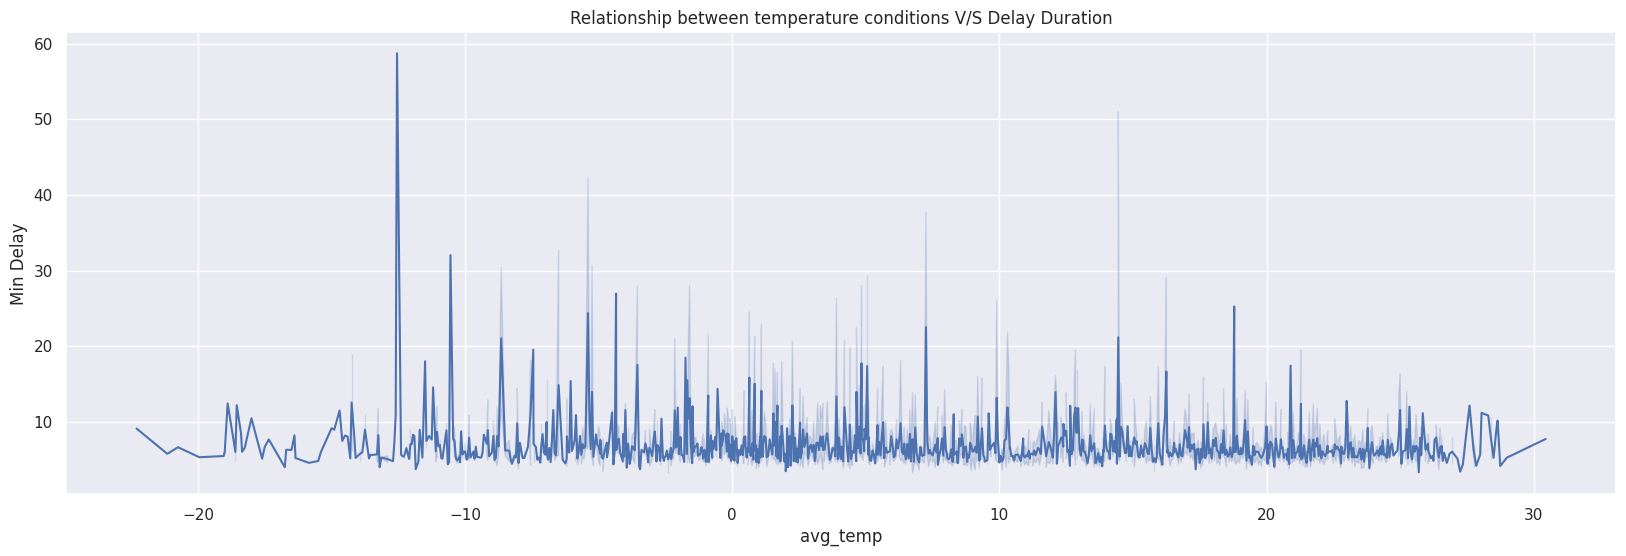

In [43]:
# Plotting avg temperature against avg. delay duration
plt.figure(figsize=(20,6))
sns.lineplot(x='avg_temp', y='Min Delay', data=delay_avg)
plt.title('Relationship between temperature conditions V/S Delay Duration')
plt.show()

##2.6 - Hourly Trends

In [44]:
# Converting Time attribute from Object to TimeStamp and creating a new attribute - Hour Bucket
data['Time'] = pd.to_datetime(data['Time'])
data['Hour'] = data['Time'].apply(lambda x: x.hour)

In [45]:
data['Hour']

0         0
1        22
2        10
3        16
4        12
         ..
46261    10
46262    15
46264    10
46265    16
46266    21
Name: Hour, Length: 42712, dtype: int64

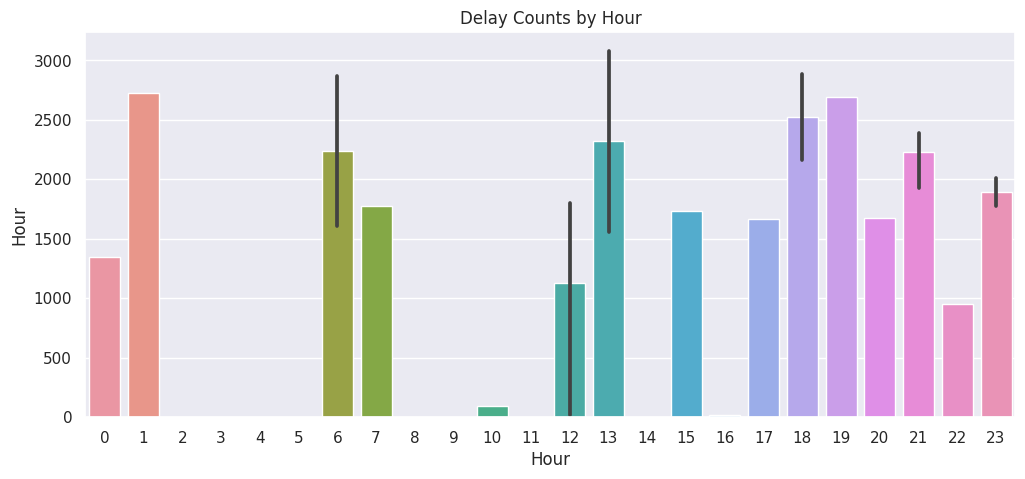

In [46]:
# Let's look at the distribution of delay durations
plt.figure(figsize=(12,5))
sns.barplot(data=data, x='Hour', y=data['Hour'].value_counts())
plt.title("Delay Counts by Hour")
plt.show()

**Key Takeaway:**

Delay frequency can be broken down into 4 major timeframes:
1. 6-7AM in the morning (start of morning rush hour)
2. 12-1PM noon time (lunch hour)
3. 3PM in the afternoon (start of afternoon rush hour)
4. 5PM - 1AM after work hours (when people get off work and start other activities such as grocery, gym, entertainment, which usually results in higher traffic)

## 2.7 - Top 10 stations by number of delays

In [47]:
# Let's quickly look at the numbers first
data['Station'].value_counts()[:10]

KENNEDY BD STATION       1912
FINCH STATION            1613
SHEPPARD WEST STATION    1601
KIPLING STATION          1580
EGLINTON STATION         1510
WILSON STATION           1420
VAUGHAN MC STATION       1231
MCCOWAN STATION          1113
BLOOR STATION            1075
COXWELL STATION           996
Name: Station, dtype: int64

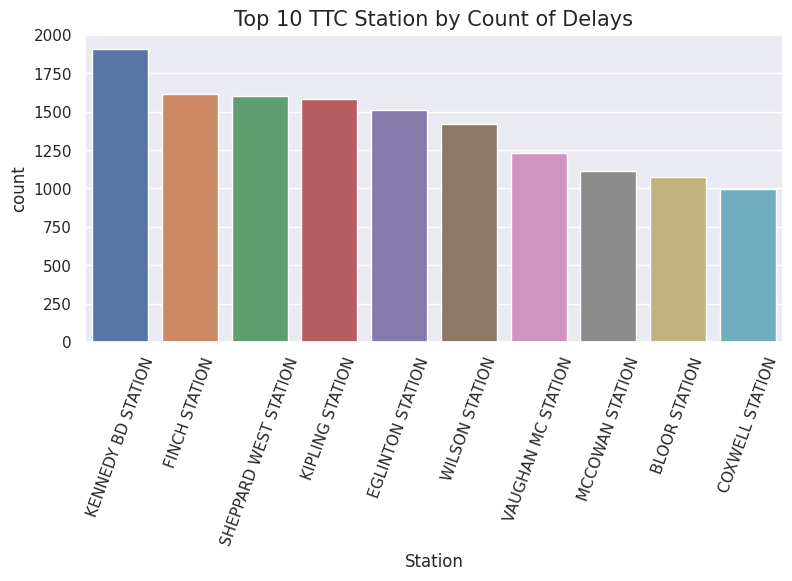

In [48]:
# Let's plot it out
plt.figure(figsize=(9,4))
plt.xticks(rotation=70)
ax = sns.countplot(data=data, x='Station', order=data['Station'].value_counts().index[:10])

plt.title("Top 10 TTC Station by Count of Delays", fontsize=15)
plt.show()

The top 4 stations by delay frequency are the terminal stations, which is expected as the terminal stations usually have more flexibility in terms of down-time, as there can be multiple trains at the terminal station ready to leave (minimize down-time for customers, but opportunity to deal with the subjected train with issues). Kennedy station

# 3 - Delay time assessment

Understanding not only the # of delays, but also the delay duration is important because it helps to identify the impact of the delay. For example, a higher occurrence of less than 1 minute delays poses a less negative impact to customer satisfaction, vs. lower occurence of more than 30 minute delays.

In [49]:
# Top 3 stations and their average delay time
top_4 = data['Station'].value_counts().index[:4]

# Define a function first
def avg_time (station, data):
  return data.loc[data['Station']==station]['Min Delay'].mean()

# Let's check the total Variance and Mean
for i in top_4:
  delay_min = round(data.loc[data['Station']==i]['Min Delay'].mean(), 2)
  delay_var = round(data.loc[data['Station']==i]['Min Delay'].var(), 2)
  print(f"{i}\nDelay Time - Mean: {delay_min}\nDelay Time - Variance: {delay_var}")
# There is a substantial gap between the variance and the mean

KENNEDY BD STATION
Delay Time - Mean: 5.2
Delay Time - Variance: 241.47
FINCH STATION
Delay Time - Mean: 4.71
Delay Time - Variance: 110.47
SHEPPARD WEST STATION
Delay Time - Mean: 5.81
Delay Time - Variance: 43.67
KIPLING STATION
Delay Time - Mean: 4.66
Delay Time - Variance: 25.74


The variance is significantly higher for Kennedy and Finch Station compared to Sheppard West and Kipling station, suggesting that Kennedy and Finch Stations likely have high counts of long and short delays (i.e. few mins vs. hours).

In [50]:
# Return top 3 codes for each of the top 4 stations
def top_codes(s):
  print(data.loc[data['Station']==s]['CODE DESCRIPTION'].value_counts()[:3])

for i in top_4:
  print(i)
  top_codes(i)

KENNEDY BD STATION
Unsanitary Vehicle                                          116
Injured or ill Customer (On Train) - Medical Aid Refused    109
No Operator Immediately Available - Not E.S.A. Related      100
Name: CODE DESCRIPTION, dtype: int64
FINCH STATION
Misc. Transportation Other - Employee Non-Chargeable    239
Unsanitary Vehicle                                      116
Operator Not In Position                                104
Name: CODE DESCRIPTION, dtype: int64
SHEPPARD WEST STATION
ATC Project                                                220
No Operator Immediately Available - Not E.S.A. Related     151
Misc. Transportation Other - Employee Non-Chargeable       116
Name: CODE DESCRIPTION, dtype: int64
KIPLING STATION
Misc. Transportation Other - Employee Non-Chargeable        155
Miscellaneous Speed Control                                 147
Injured or ill Customer (On Train) - Medical Aid Refused     87
Name: CODE DESCRIPTION, dtype: int64


**Key Takeaway:**
It is interesting to see that despite having some differences in the top 3 delay codes for each of the top 4 stations, a few common delay codes were observed:
1. Unsanitary Vehicle
2. Misc. transporation Other - Employee Non-Chargeable

As a next step, it would be worthwhile to look into the definition of these delay codes and any relevant information. For example, how many sanitary cycles does the TTC go through each day? Is it being performed ONLY at the terminal stations?

In [51]:
# From the previous assessments, two of the common delay codes amongst the top 3 stations are:
# Unsanitary Vehicle and Misc. transporation Other - Employee Non-Chargeable

# Top 2 Delay Codes
top_delay = ['Unsanitary Vehicle', 'Misc. Transportation Other - Employee Non-Chargeable']

# Define a function first
def avg_time (delay, data):
  return data.loc[data['CODE DESCRIPTION']==delay]['Min Delay'].mean()

for i in top_delay:
  print(i)
  print(round(avg_time(i, data),2))


Unsanitary Vehicle
4.08
Misc. Transportation Other - Employee Non-Chargeable
4.02


Both of these delay codes have an average duration of 4 minutes, which is quite substaintial, considering that the usual wait time for a subway is approxmiately 2 minutes (based on experience).